# Predicting Cardiovascular Disease Using Random Forest

### Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning) # removes warnings for conflicts in future versions

### Import Dataset

#### data set by  - source:

In [2]:
df = pd.read_csv('cardio_train.csv', sep = ';')

## look at dataset

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### drop id 

In [4]:
df.drop(['id'],axis=1,inplace = True)

In [5]:
df.shape

(70000, 12)

### check data type and null values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


## Exploratory Data Analysis

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


### check pearson correlation with Presence or absence of cardiovascular disease
Cardio included for sanity check

In [8]:
df.corrwith(df['cardio'], axis=0, drop=False, method='pearson')

age            0.238159
gender         0.008109
height        -0.010821
weight         0.181660
ap_hi          0.054475
ap_lo          0.065719
cholesterol    0.221147
gluc           0.089307
smoke         -0.015486
alco          -0.007330
active        -0.035653
cardio         1.000000
dtype: float64

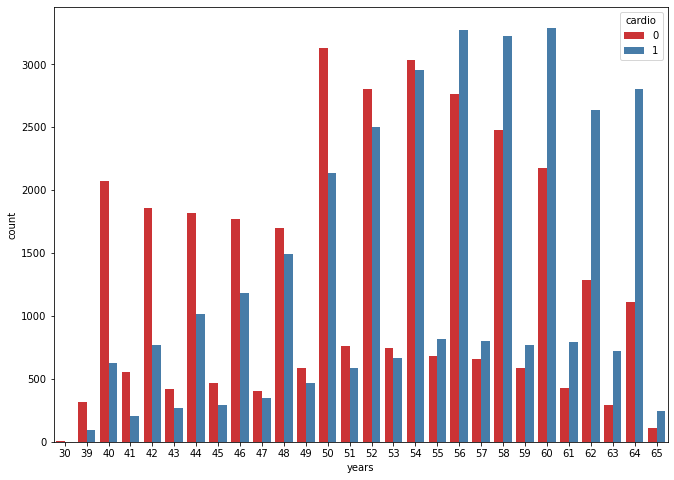

In [9]:
rcParams['figure.figsize'] = 11, 8
df['years'] = (df['age'] / 365).round().astype('int')  # convert age from days to years
sns.countplot(x='years', hue='cardio', data = df, palette="Set1");

checking categorical values

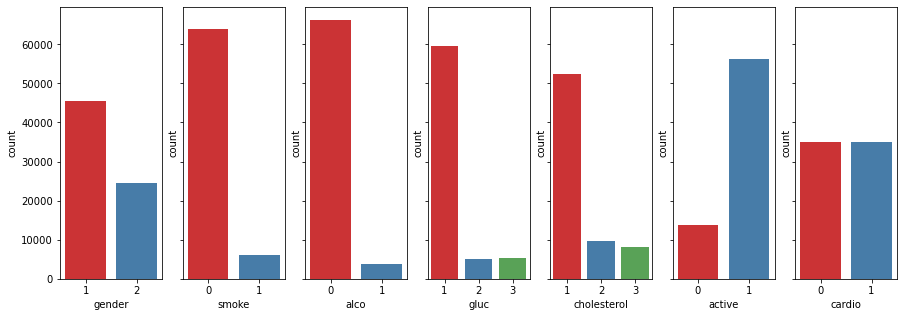

In [10]:
f, axes = plt.subplots(1, 7, figsize=(15, 5), sharex=False,sharey=True)
i=0
for x in ['gender','smoke','alco','gluc','cholesterol','active','cardio']:
    sns.countplot(x,data=df,ax=axes[i],palette="Set1")
    i+=1

Clean data set

remove outlies and duplicates

In [11]:
df.duplicated().sum()

24

In [12]:
data = df.drop_duplicates() #create copy and leave original as is

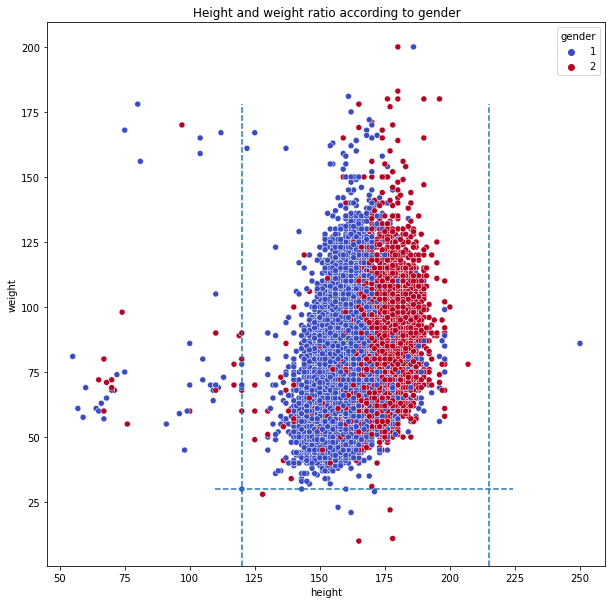

In [13]:
f, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data=data, x="height", y="weight",hue='gender', palette= "coolwarm",legend = 'full')
ax.axvline(120, ls='--',ymax=0.85)
ax.axvline(215, ls='--',ymax=0.85)
ax.axhline(30, ls='--',xmin=0.3,xmax=0.835)
plt.title("Height and weight ratio according to gender")
plt.show()

remove unreasonable height and weight

In [14]:
data = data[data.height >= 120]
data = data[data.height <= 215]
data = data[data.weight >= 30]

In [15]:
data['BMI'] = data['weight']/((data['height']/100)**2)

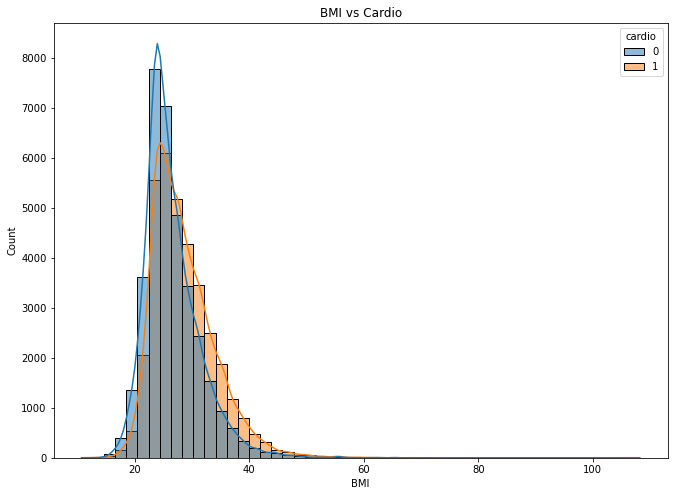

In [16]:
sns.histplot(data,x='BMI',hue='cardio',kde = True,bins=50)
plt.title('BMI vs Cardio')
plt.show()

In [17]:
data = data[data.BMI <=45]

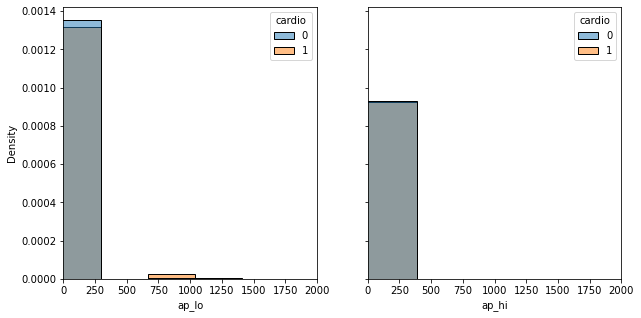

In [18]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True,sharey=True)
plt.xlim(0, 2000)
sns.histplot(data, x="ap_hi", hue="cardio",bins=30,stat="density",ax=axes[1])
sns.histplot(data, x="ap_lo", hue="cardio",bins=30,stat="density",ax=axes[0])
f.suptitle('')
plt.show()

<div>
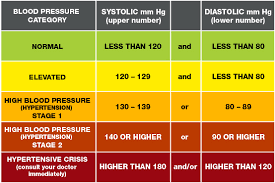
<div/>
source: https://www.heart.org/-/media/images/health-topics/high-blood-pressure/rainbow-chart/blood-pressure-readings-chart.jpg

In [19]:
data = data[70 < data.ap_hi]
data = data[data.ap_hi< 240] 
data = data[40 < data.ap_lo] 
data = data[data.ap_lo< 180]
data = data[data.ap_hi> data.ap_lo]

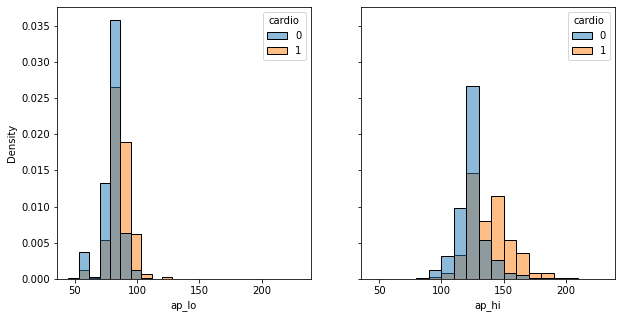

In [20]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True,sharey=True)
#plt.xlim(0, 2000)
sns.histplot(data, x="ap_hi", hue="cardio",bins=15,stat="density",ax=axes[1])
sns.histplot(data, x="ap_lo", hue="cardio",bins=15,stat="density",ax=axes[0])
f.suptitle('')
plt.show()

Check correlation on the cleaned data

In [21]:
data.corrwith(data['cardio'], axis=0, drop=False, method='pearson')

age            0.239796
gender         0.008466
height        -0.010577
weight         0.180096
ap_hi          0.428824
ap_lo          0.341377
cholesterol    0.221318
gluc           0.089055
smoke         -0.015941
alco          -0.008336
active        -0.037651
cardio         1.000000
years          0.239391
BMI            0.193543
dtype: float64

remove subjective data with low correlation

In [22]:
data.drop(['active','alco','smoke'],axis=1, inplace = True)

In [23]:
X = data.drop(['cardio'],axis=1)
y = data['cardio'].copy()

In [24]:
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0,53
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1,62
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1,52
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61


### Prepare for model

In [25]:
X = data.drop(['cardio'],axis=1)
y = data['cardio'].copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

normalize data

In [27]:
scaler=StandardScaler()

X_train_s=X_train.copy()
X_train_s[['age','ap_hi','ap_lo','BMI']]=scaler.fit_transform(X_train_s[['age','ap_hi','ap_lo','BMI']])
normalized_x_train = pd.DataFrame(X_train_s, columns = X_train.columns)
X_train=normalized_x_train
X_test_s=X_test.copy()
X_test_s[['age','ap_hi','ap_lo','BMI']]=scaler.transform(X_test_s[['age','ap_hi','ap_lo','BMI']])
normalized_x_test = pd.DataFrame(X_test_s, columns = X_test.columns)
X_test=normalized_x_test

## Guassian Naive Bayes for baseline

In [28]:
model_NB = GaussianNB()
model_NB.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [29]:
model_NB.score(X_train,y_train)

0.7062649274297262

In [30]:
score_NB = model_NB.score(X_test,y_test)

In [31]:
score_NB

0.7126690182245737

## Random Forest

In [32]:
model_RF = RandomForestClassifier(n_estimators=100, max_depth =7)
model_RF.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
model_RF.score(X_train,y_train)

0.7378467756751791

In [34]:
score_RF = model_RF.score(X_test,y_test)

In [35]:
score_RF

0.7344209288653734

### Grid search for hyper-paramters

In [36]:


grid = {"n_estimators" : np.arange(10,150,10), "max_depth" : np.arange(5,15,1)}

model_cv = GridSearchCV(model_RF, grid, cv=3) # GridSearchCV
model_cv.fit(X_train,y_train)# Fit

print("Tuned hyperparameter n_estimators: {}".format(model_cv.best_params_)) 
print("Best score: {}".format(model_cv.best_score_))

Tuned hyperparameter n_estimators: {'max_depth': 10, 'n_estimators': 110}
Best score: 0.7335109161027636


In [37]:
score_GS = model_cv.score(X_test,y_test)

In [38]:
score_GS

0.7367724867724867

# Scores

## Naive Bayes

In [39]:
score_NB

0.7126690182245737

## Random Forest

In [40]:
score_RF

0.7344209288653734

## Grid search optimized Random Forest

In [41]:
score_GS

0.7367724867724867